In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import ndimage
import torch
import torch.optim as optim
from torchvision import transforms, models
import torch.nn as nn
import pdb

In [173]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.resnet34(pretrained=True).cuda()
#vgg = models.vgg19(pretrained=True).features.cuda()

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 16154947.47it/s]


In [3]:
def img_to_tensor(image):
    in_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
    return in_transform(image)

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize((size,size)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image.cuda()

In [5]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [155]:
def show_all(images):
    img_n = len(images)
    rows = int(np.sqrt(img_n))
    cols = (img_n+rows-1) // rows
    _, axs = plt.subplots(rows, cols, figsize=(15*rows,15*cols))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(im_convert(img.squeeze()))
        ax.axis('off')

In [163]:
def get_random_img(size):
    opt_img = np.random.uniform(0, 1, size=(size,size,3)).astype(np.float32)
    #opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])  
    opt_pil = Image.fromarray(np.uint8(opt_img*255))
    opt_tensor = img_to_tensor(opt_pil).cuda()
    opt_tensor = opt_tensor[None].cuda()
    return opt_tensor

In [38]:
part_vgg = nn.Sequential(*list(vgg.children())[:24])


In [12]:
def loss_fun(img, tar):
    return torch.mean((img - tar)**2)


In [13]:
input_img.shape, content.shape

(torch.Size([1, 3, 16, 16]), torch.Size([1, 3, 16, 16]))

In [14]:
part_vgg(input_img).shape

torch.Size([1, 512, 2, 2])

In [15]:
loss_fun(part_vgg(input_img), part_vgg(content))

tensor(0.0003, device='cuda:0')

In [17]:
part_vgg(content)[0,0,:,:]

tensor([[-0.0262,  0.0117],
        [-0.0134, -0.0065]], device='cuda:0')

In [30]:
def trainLBFGS(opt_img, content_img, until=0.01):
    def one_step():
        output = part_vgg(opt_img)
        loss = loss_fun(output, target)
        optimizer.zero_grad()
        loss.backward()
        return loss
    target = part_vgg(content_img)
    opt_img.requires_grad=True
    optimizer = optim.LBFGS([opt_img])
    lss = float("inf")
    epoch = 0
    while lss > until:
        lss = optimizer.step(one_step)
        epoch +=1
        if epoch % 10 == 0: print(lss)

In [23]:
def trainAdam(opt_img, content_img, until=0.01, lr=0.01):
    optimizer = optim.Adam([opt_img], lr=0.01)
    target = part_vgg(content_img) 
    opt_img.requires_grad=True
    lss = float("inf")
    epoch = 0
    while lss > until:
        output = part_vgg(opt_img)
        lss = loss_fun(output, target)
        optimizer.zero_grad()
        lss.backward()
        optimizer.step()
        epoch += 1
        if epoch % 500 == 0: print(lss)

In [174]:
for idx, layer in enumerate(vgg.children()):
    print(idx, layer)

0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 ReLU(inplace)
3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [142]:
def trainOnLayers(opt_imgs, content_img, layers, epochs=1500, lr=0.1):
    assert len(opt_imgs) == len(layers)
    optims = []
    for i in range(len(layers)):
        optims.append(optim.Adam([opt_imgs[i]], lr=lr))
        opt_imgs[i].requires_grad = True
    target = content_img
    targets =[]
    for idx, layer in enumerate(vgg.children()):
        if idx > np.max(layers): break
        target = layer(target)
        if idx in layers:
            targets.append(target.clone())
    for epoch in range(epochs):
        losses = []
        for idx in range(len(layers)):
            target = targets[idx]
            net = nn.Sequential(*list(vgg.children())[:layers[idx]+1])
            output =  net(opt_imgs[idx])
            lss = loss_fun(output, target)
            optims[idx].zero_grad()
            lss.backward()
            optims[idx].step()
            losses.append(lss.item())
        if epoch % 100 == 99: print(losses)
    return losses

[0.5116658806800842, 17.540830612182617, 3.8416366577148438]
[0.2515757083892822, 9.278678894042969, 1.3619353771209717]
[0.15436044335365295, 6.069194316864014, 0.7997002005577087]
[0.10614541172981262, 4.4164228439331055, 0.5759140849113464]
[0.07862628251314163, 3.428976535797119, 0.4508343040943146]
[0.06169753894209862, 2.776704788208008, 0.3706064820289612]
[0.049841124564409256, 2.3177428245544434, 0.3143314719200134]
[0.04107186943292618, 1.9842863082885742, 0.27264082431793213]
[0.03416194021701813, 1.7250645160675049, 0.2404230237007141]
[0.02858213521540165, 1.5219812393188477, 0.21488547325134277]
[0.024035053327679634, 1.3573981523513794, 0.19398285448551178]
[0.020203519612550735, 1.2219195365905762, 0.17636504769325256]
[0.01646735891699791, 1.1073435544967651, 0.16151782870292664]
[0.013494173996150494, 1.0094140768051147, 0.14870736002922058]
[0.011466184630990028, 0.9255231022834778, 0.1375986933708191]
[0.010117106139659882, 0.8539695739746094, 0.1278579831123352]
[0

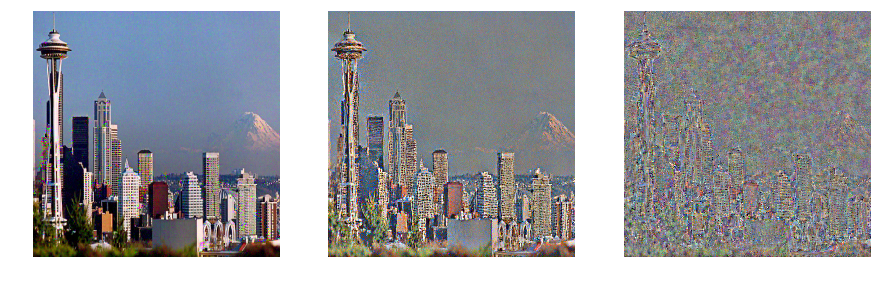

In [161]:
layers = [6,16,25]
size = 256
imgs = [get_random_img(size) for i in range(len(layers))]
content = load_image('images/space_needle.jpg', max_size=size)
trainOnLayers(imgs, content, layers, 4000,lr=0.01)
show_all(imgs)

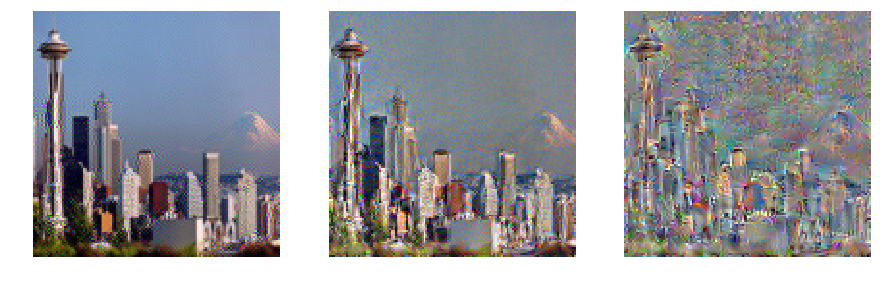

In [158]:
show_all(imgs)

training  32
[0.02902097813785076, 0.09628795087337494, 0.03022468462586403, 0.02028672769665718]
[0.00802415981888771, 0.04328126460313797, 0.01151946745812893, 0.019799131900072098]
[0.0027884775772690773, 0.03001856803894043, 0.005744498688727617, 0.01588127762079239]
[0.0014026183634996414, 0.02401343733072281, 0.003936127293854952, 0.016129080206155777]
[0.0008544576703570783, 0.020120546221733093, 0.003136872546747327, 0.013293914496898651]
training  64
[0.001458840211853385, 0.08892685920000076, 0.028787031769752502, 0.014856788329780102]
[0.0002997256815433502, 0.03917146101593971, 0.011406676843762398, 0.00965903326869011]
[0.00011499508400447667, 0.02545863203704357, 0.0060909707099199295, 0.007197787053883076]
[6.046620546840131e-05, 0.01923159882426262, 0.0040713949128985405, 0.005457750055938959]
[3.681069574668072e-05, 0.015389366075396538, 0.0031629547011107206, 0.004440824966877699]
training  128
[0.00028946573729626834, 0.06894893944263458, 0.03661176562309265, 0.01263

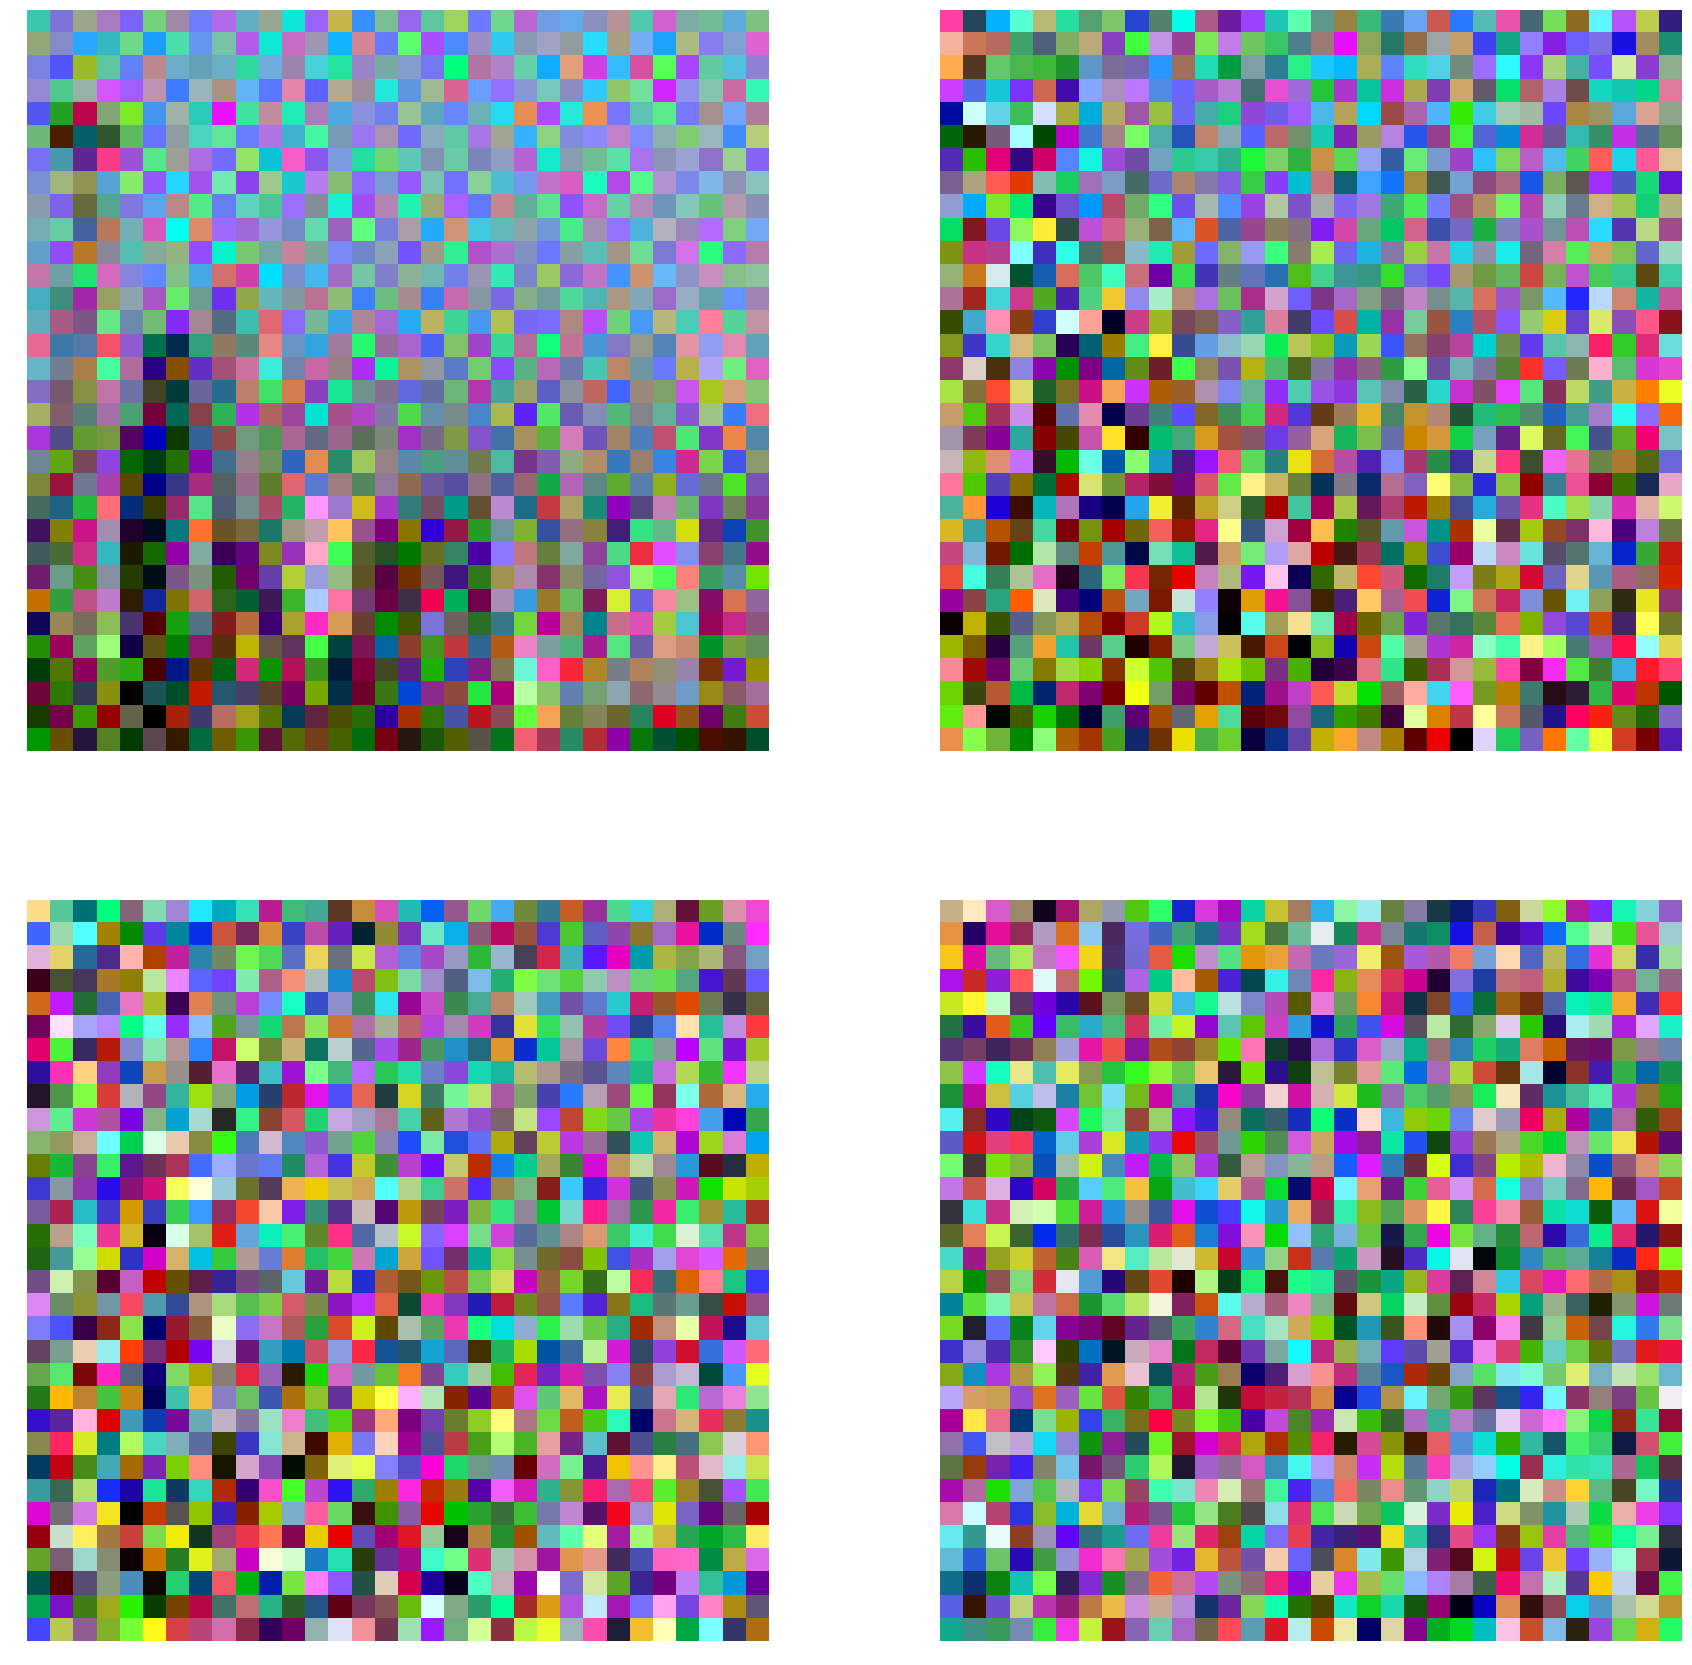

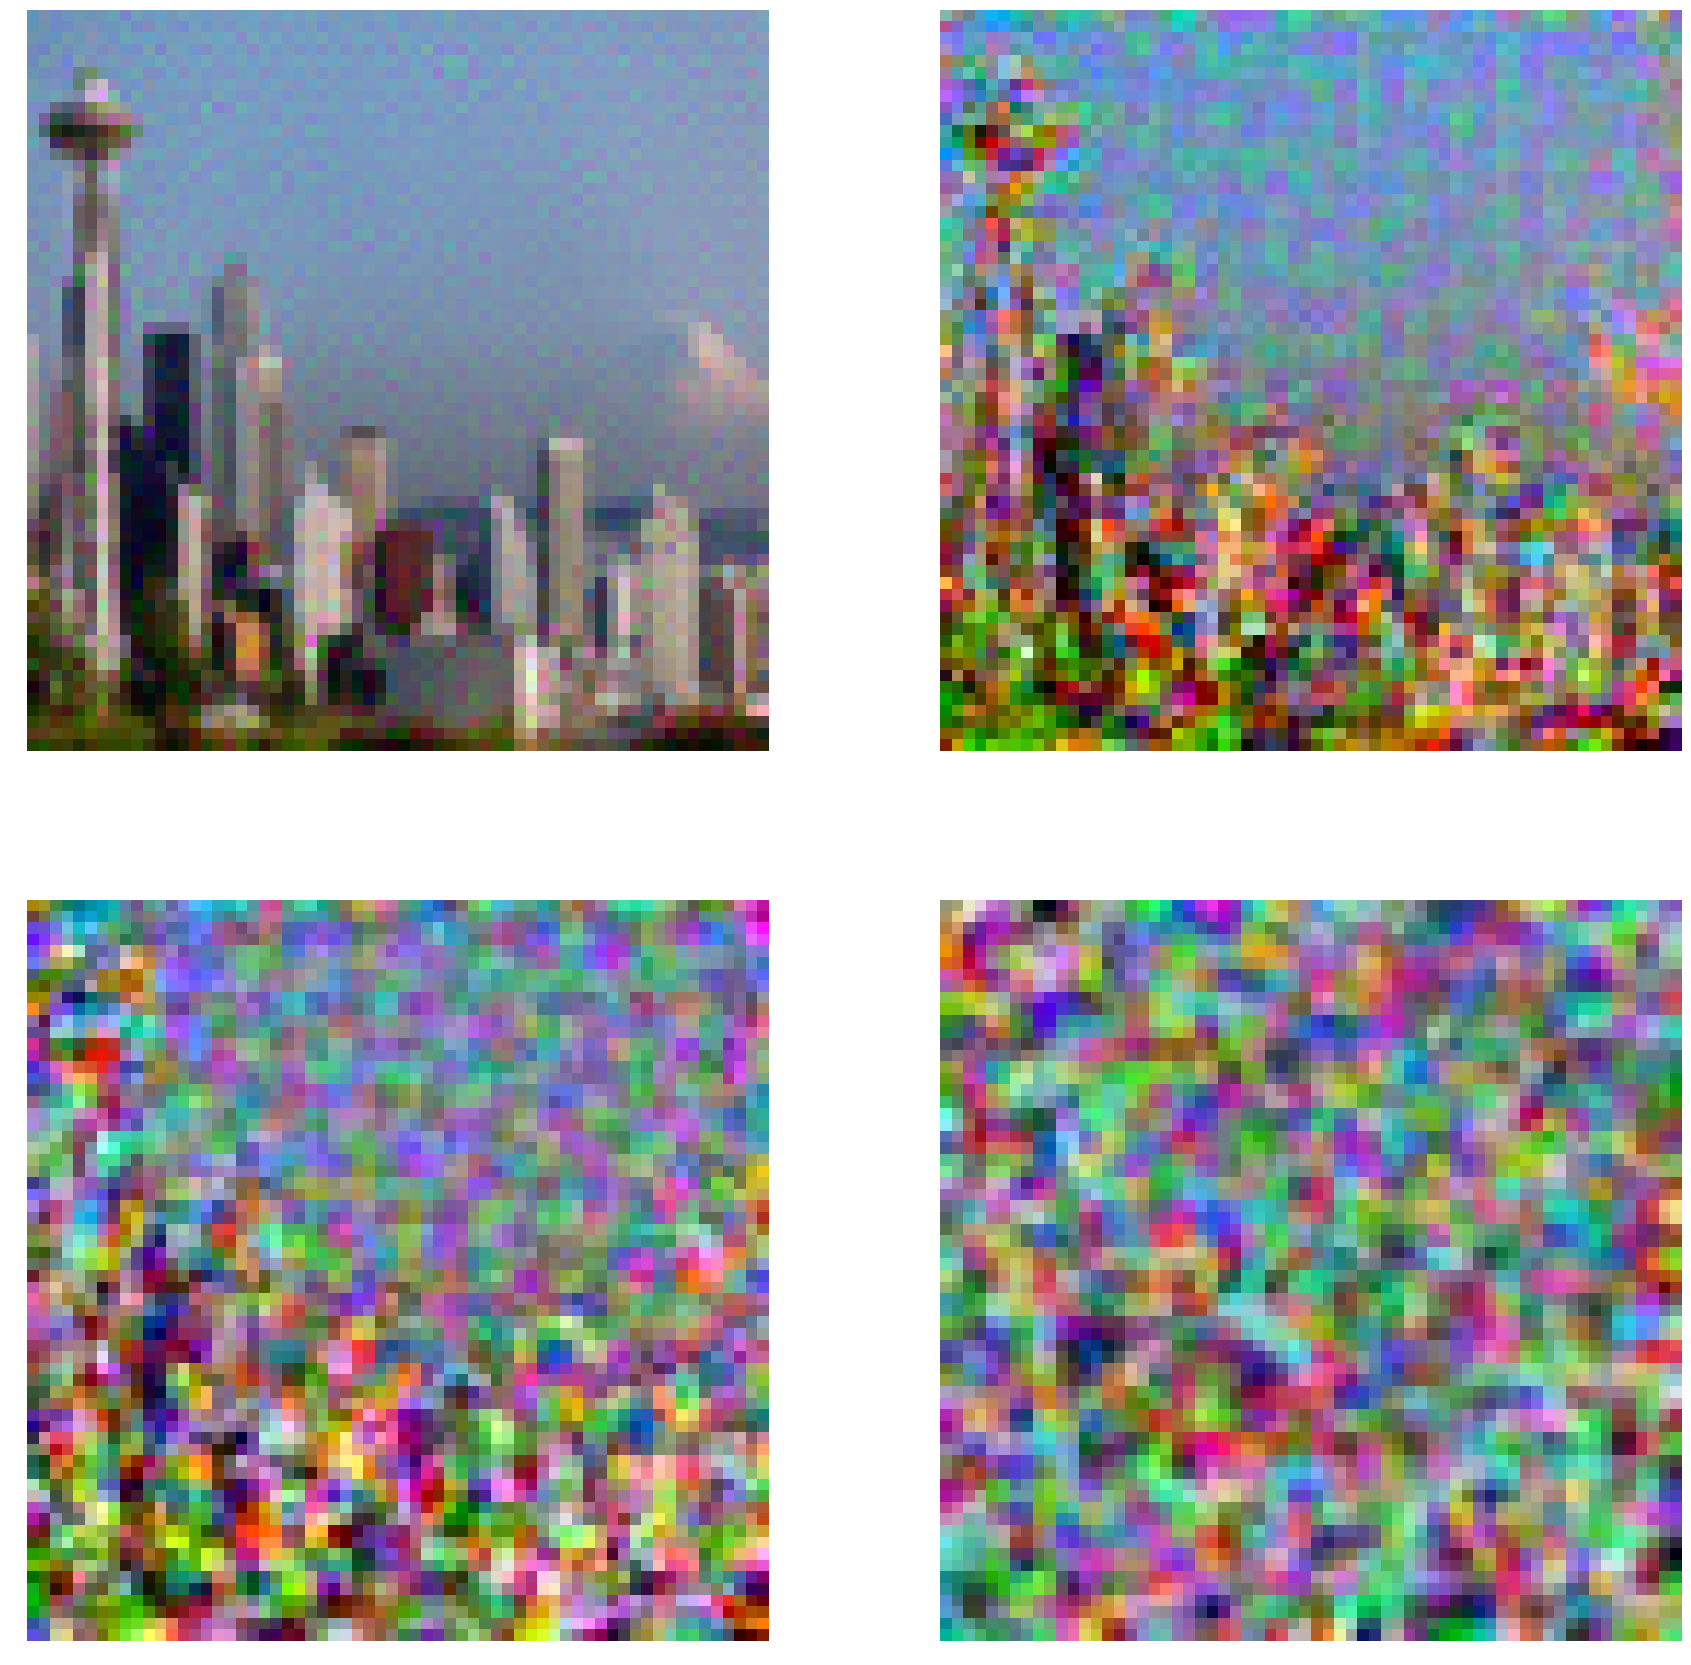

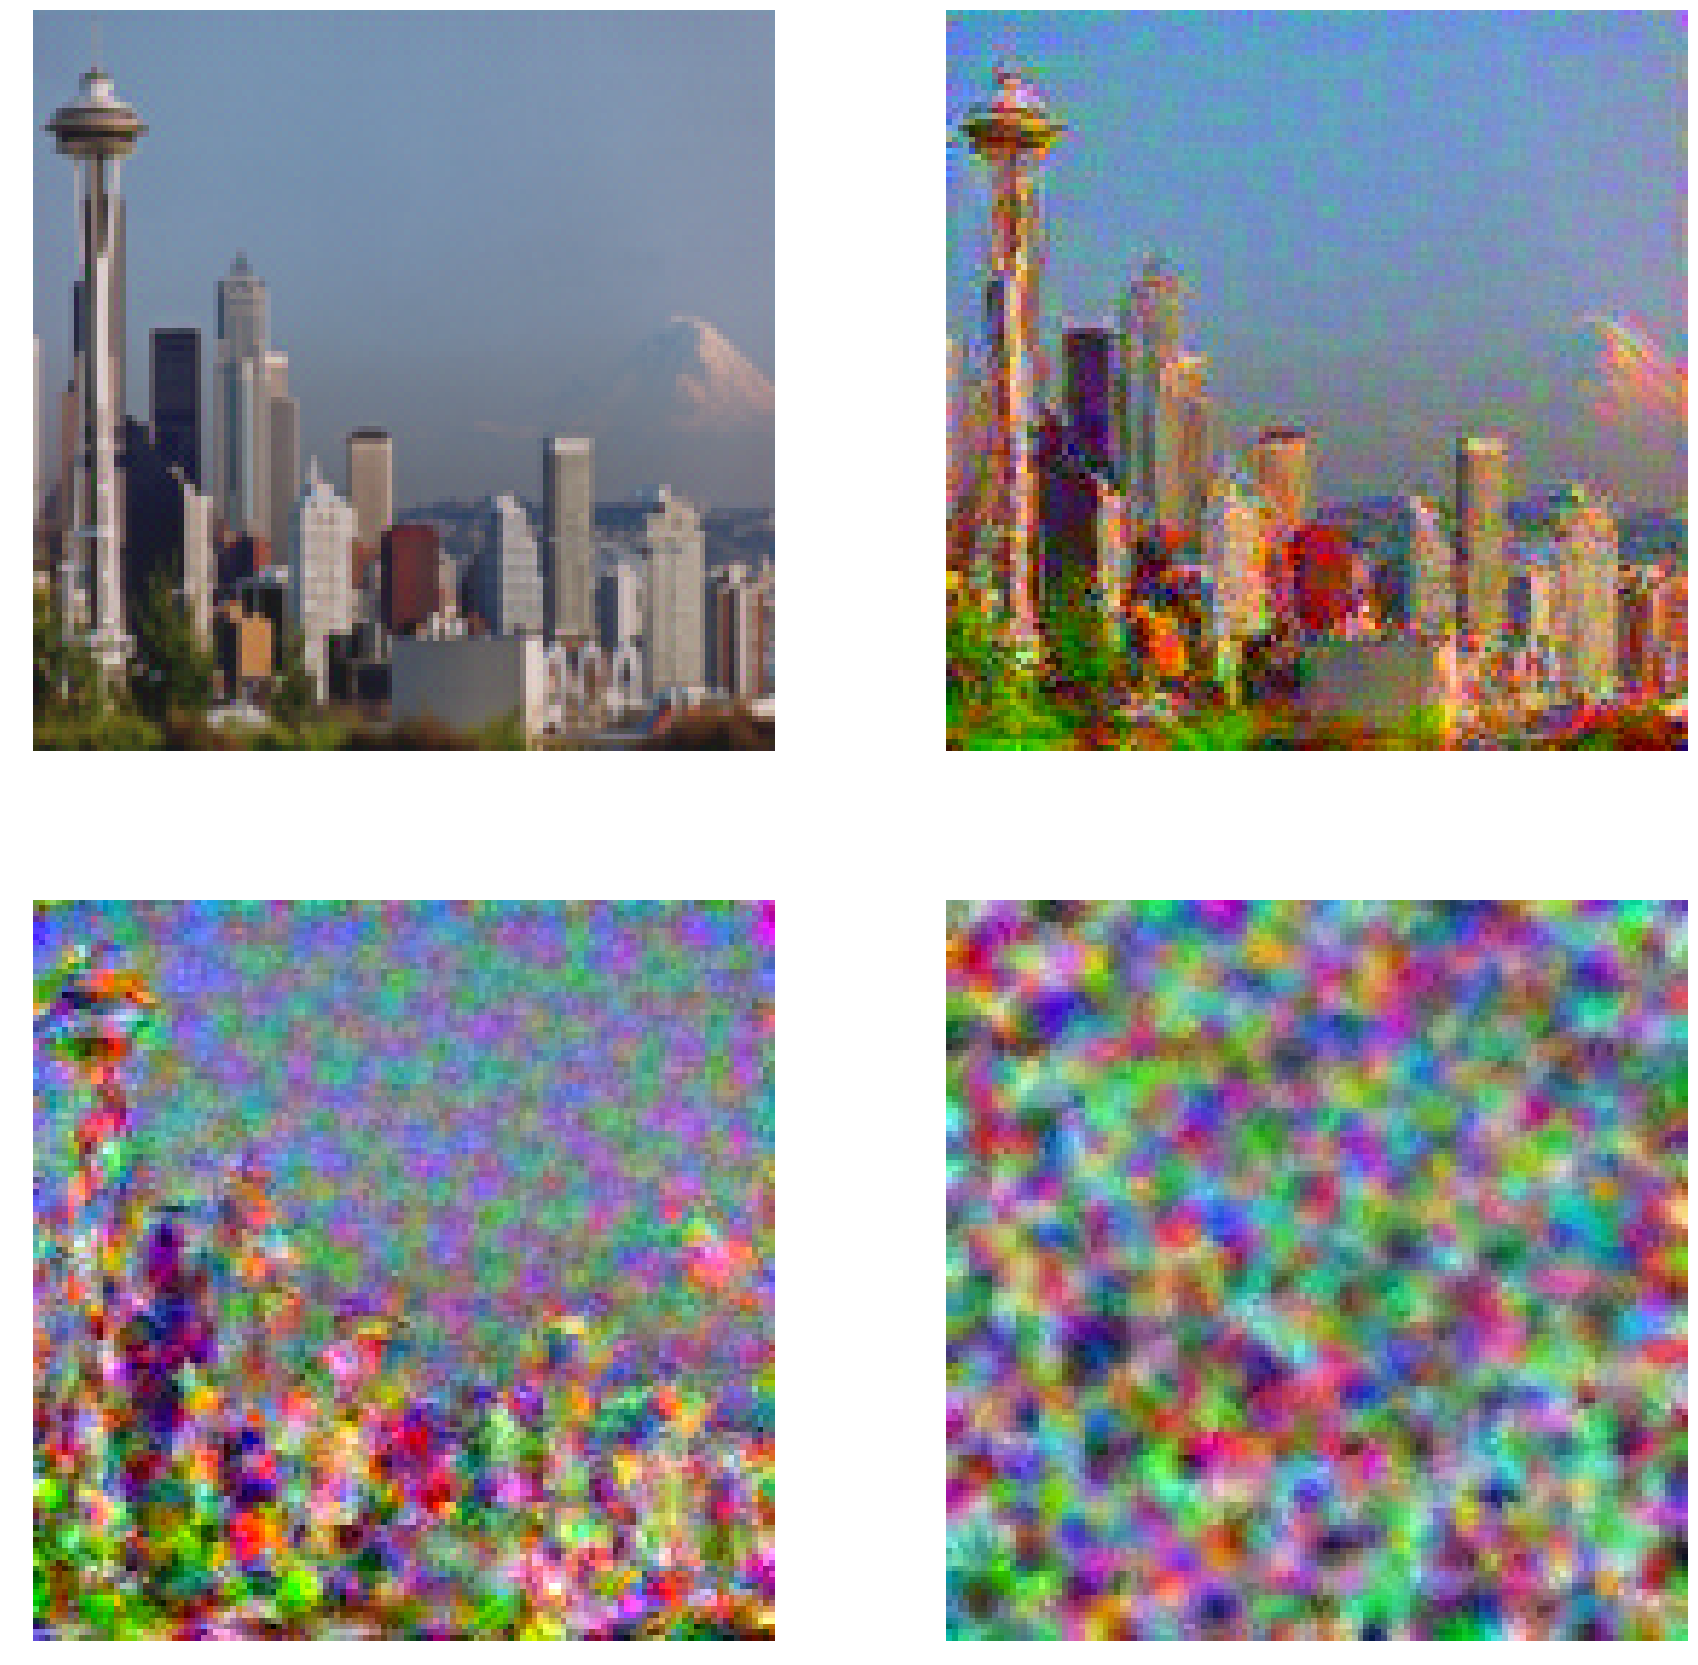

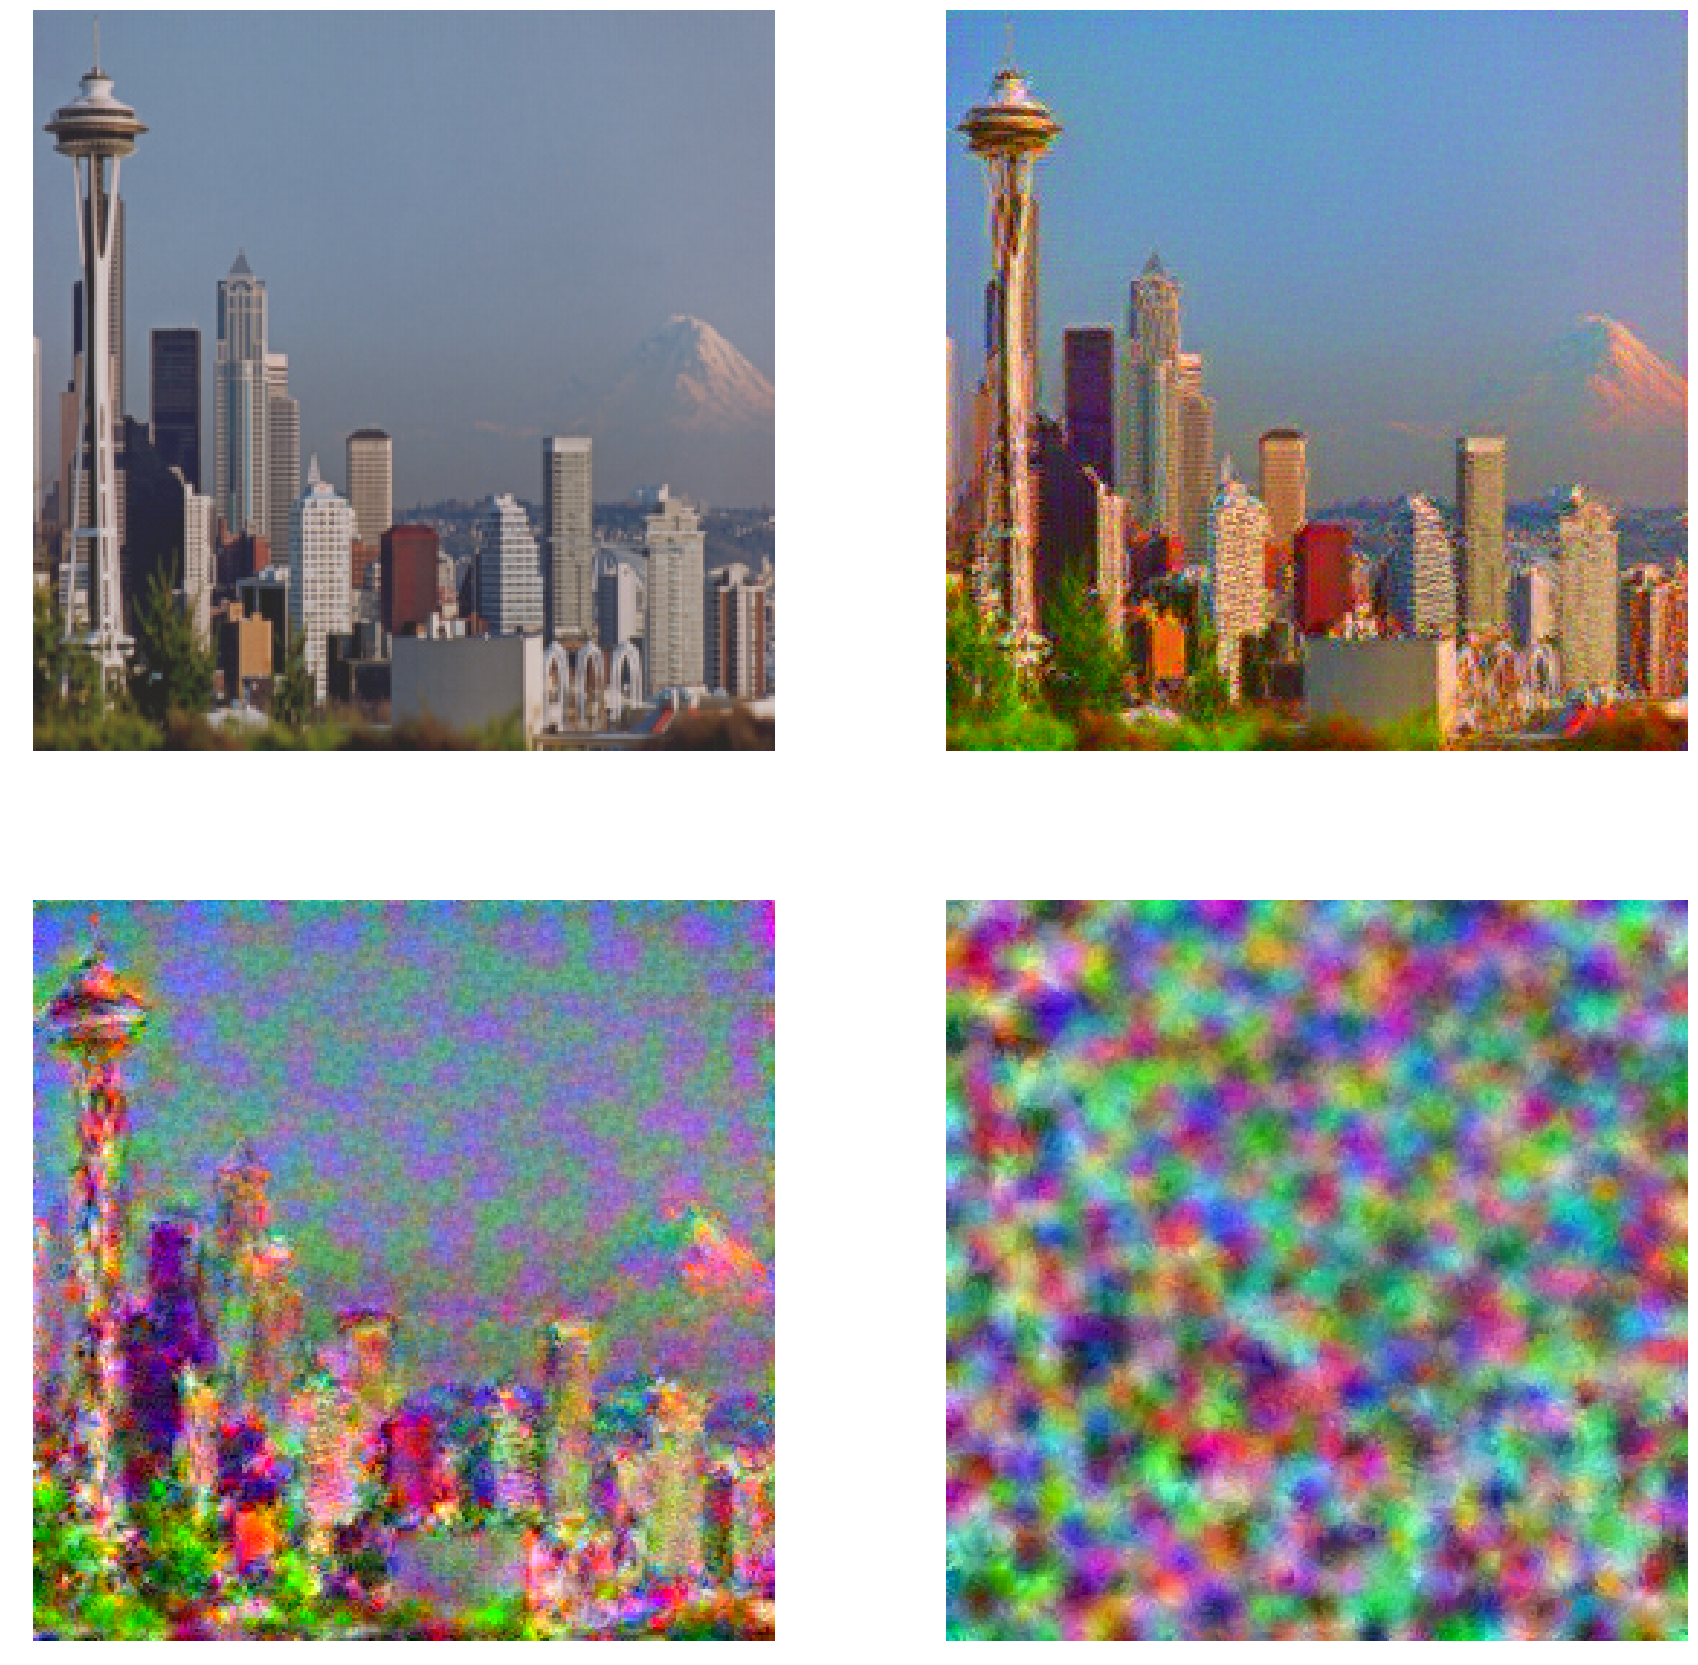

In [175]:
%%time
#layers = [8,17,26, 35]
layers = [2,4,5,6]
size = 32
imgs = [get_random_img(size) for i in range(len(layers))]
TARGET_SIZE = 256
while size <= TARGET_SIZE:
    content = load_image('images/space_needle.jpg', max_size=size)
    print('training ', size)
    trainOnLayers(imgs, content, layers, 500,lr=0.01)
    show_all(imgs)
    if size < TARGET_SIZE:
        imgs = [nn.Upsample(scale_factor=2, mode='bilinear')(img).detach_() for img in imgs]
    size *= 2

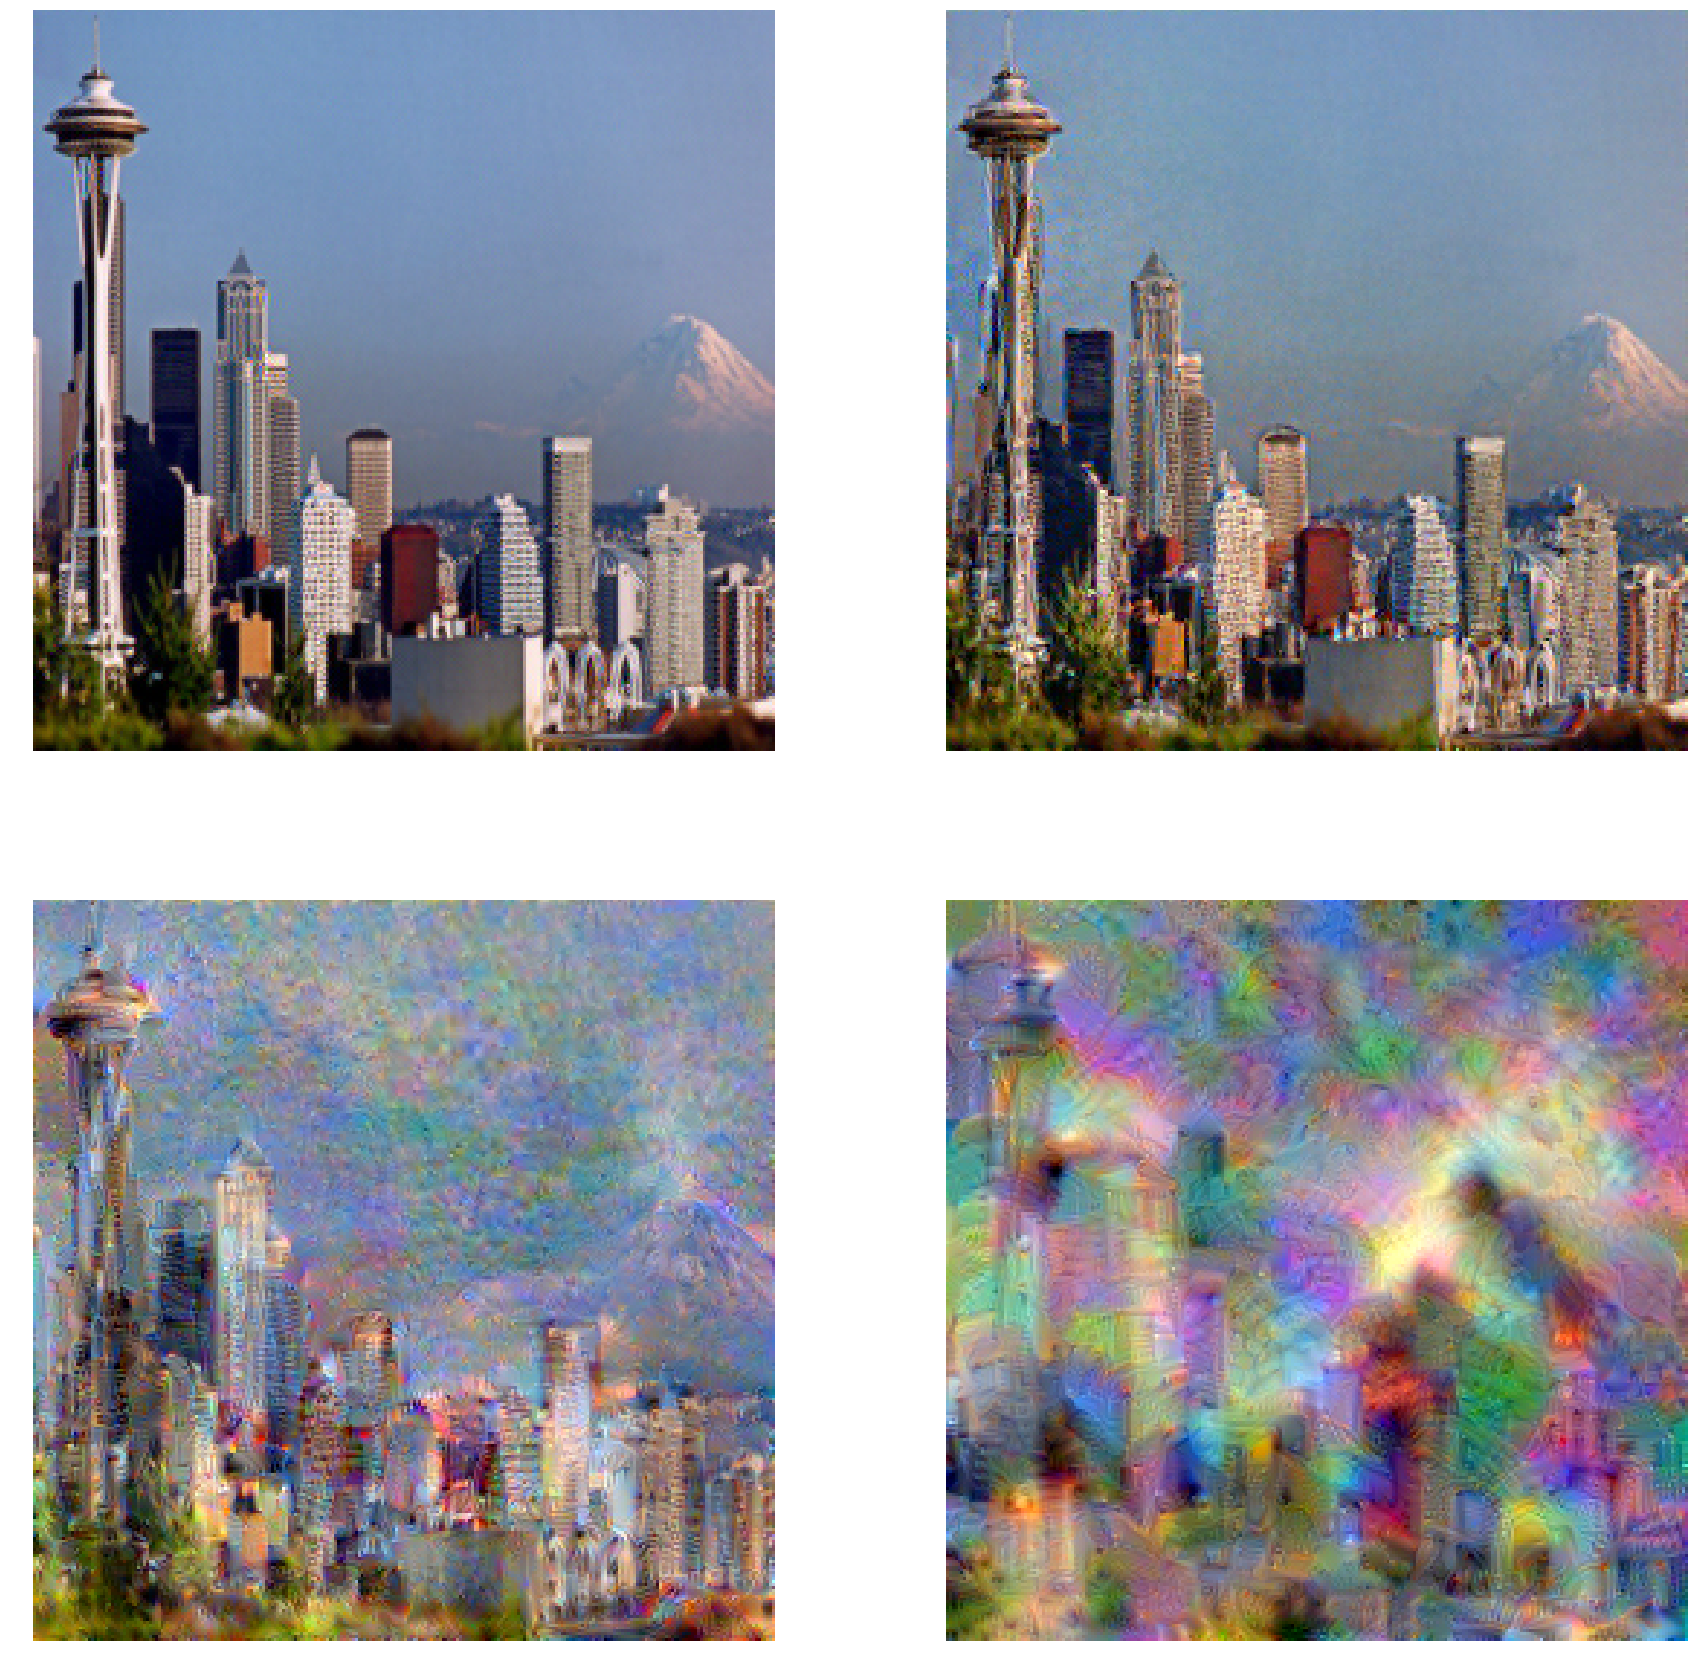

In [165]:
show_all(imgs)

In [136]:
part5 = nn.Sequential(*list(vgg.children())[:6])
part6 = nn.Sequential(*list(vgg.children())[:7])
l1=loss_fun(part5(imgs[0]), part5(content))
l2=loss_fun(part6(imgs[1]), part6(content))
(l1,l2)

(tensor(0.2862, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.0494, device='cuda:0', grad_fn=<MeanBackward1>))

training  16
tensor(0.6387, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2251, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1227, device='cuda:0', grad_fn=<MeanBackward1>)
CPU times: user 10.2 s, sys: 2.11 s, total: 12.3 s
Wall time: 12.3 s
training  32
tensor(0.7780, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3910, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2740, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2001, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1432, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1104, device='cuda:0', grad_fn=<MeanBackward1>)
CPU times: user 19.1 s, sys: 4.04 s, total: 23.1 s
Wall time: 23.2 s
training  64
tensor(1.0367, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5515, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3728, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2700, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2082, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1656, device='cu

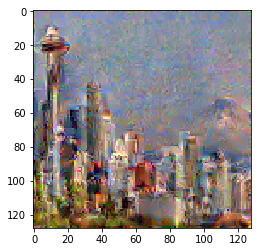

In [39]:
size = 16
input_img = get_random_img(size)
TARGET_SIZE = 128
while size <= TARGET_SIZE:
    content = load_image('images/space_needle.jpg', max_size=size)
    print('training ', size)
    %time trainAdam(input_img, content,0.1)
    plt.imshow(im_convert(input_img[0]))
    if size < TARGET_SIZE:
        input_img = nn.Upsample(scale_factor=2, mode='bilinear')(input_img)
        input_img = input_img.detach_()
    size *= 2

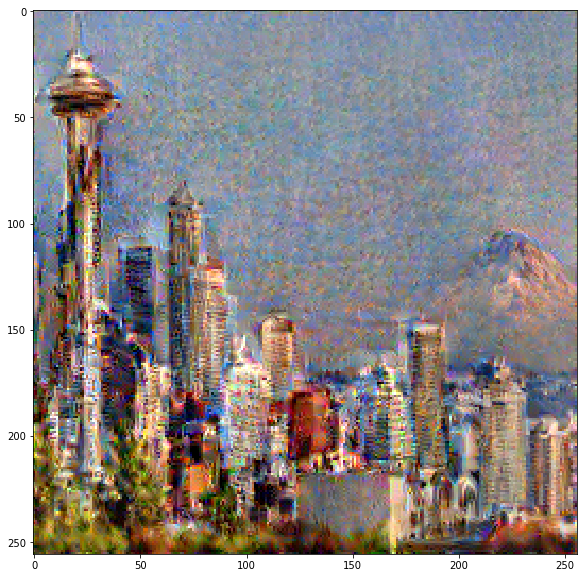

In [47]:
plt.figure(figsize = (10,10))
plt.imshow(im_convert(input_img[0]))

training  16
tensor(0.1413, device='cuda:0', grad_fn=<MeanBackward1>)
training  32
tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1523, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0978, device='cuda:0', grad_fn=<MeanBackward1>)
training  64
tensor(0.7707, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3366, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2221, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1704, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1374, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1146, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward1>)
training  128
tensor(0.6272, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.3188, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2208, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1758, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1482, device='cuda:0', gra

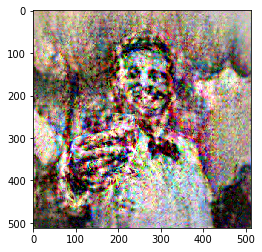

In [113]:
%%time
size = 16
input_img = get_random_img(size)
while size <= 256:
    content = load_image('images/slawek.jpg', max_size=size)
    print('training ', size)
    train(input_img, content,0.1)

    input_img = nn.Upsample(scale_factor=2, mode='bilinear')(input_img)
    input_img = input_img.detach_()
    size *= 2
plt.imshow(im_convert(input_img[0]))

In [ ]:
input_img.shape

In [ ]:
trainAdam(input_img, load_image('images/slawek.jpg', max_size=512),0.02, 0.001)

tensor(0.0478, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0463, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0440, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0421, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0351, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0343, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward1>)


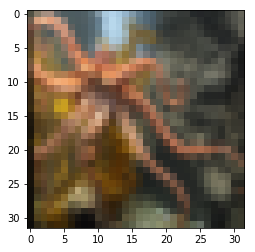

In [107]:
plt.imshow(im_convert(content[0]))